<a href="https://colab.research.google.com/github/JanePer/AI---PORTFOLIO/blob/main/Task7(Pro)_%D0%92%D1%80%D0%B5%D0%BC%D0%B5%D0%BD%D0%BD%D1%8B%D0%B5_%D1%80%D1%8F%D0%B4%D1%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Прогнозирование акций Лукойл**

**1. Импорт библиотек**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import re
import math
from google.colab import drive
from IPython.display import clear_output
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten, Input, concatenate, Conv1D, Conv2D, LSTM, GlobalMaxPooling1D, MaxPooling1D, RepeatVector
from tensorflow.keras import utils
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from sklearn.preprocessing import StandardScaler, MinMaxScaler

drive.mount('/content/drive')

Mounted at /content/drive


**2. Загрузка базы данных**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!rm -R '/content/texts' #remove texts directory
!unzip -q '/content/drive/MyDrive/Colab Notebooks/shares.zip' -d '/content/texts' #unzip to created `texts` directory
base_data = pd.read_csv('/content/texts/18_19.csv', sep=';')
base_data.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
rm: cannot remove '/content/texts': No such file or directory


,DATE,TIME,OPEN,MAX,MIN,CLOSE,VOLUME
0,03.01.2018,10:00:00,3341.0,3356.0,3340.0,3355.0,6088
1,03.01.2018,10:01:00,3355.0,3359.0,3353.0,3353.0,1624
2,03.01.2018,10:02:00,3351.5,3357.5,3351.5,3357.5,722
3,03.01.2018,10:03:00,3354.5,3360.0,3354.5,3358.0,3034
4,03.01.2018,10:04:00,3358.0,3360.0,3351.5,3360.0,1427


In [ ]:
base_data16 = pd.read_csv('/content/texts/16_17.csv', sep=';')
base_data18 = pd.read_csv('/content/texts/18_19.csv', sep=';')
data16_17 = base_data16.iloc[:,2:]
data18_19 = base_data18.iloc[:,2:]
print(data16_17.shape)
print(data18_19.shape)

(263925, 5)
(217947, 5)


In [ ]:
# Объединяем базы из двух файлов
data = pd.concat([data16_17,data18_19]) 
data.head()

,OPEN,MAX,MIN,CLOSE,VOLUME
0,2351.0,2355.8,2350.0,2350.0,2547
1,2352.9,2355.7,2350.0,2355.7,195
2,2355.6,2356.0,2351.4,2354.1,257
3,2354.5,2355.0,2351.2,2353.7,763
4,2353.1,2353.9,2353.1,2353.6,231


In [ ]:
data['DiffOpenClose']=data['CLOSE']-data['OPEN']
data['DiffMaxMin']=data['MAX']-data['MIN']
data['DiffOpenClose_ABS']=abs(data['CLOSE']-data['OPEN'])
data['MultiOpenClose']=data['CLOSE']*data['OPEN']
data['MultiMaxMin']=data['MAX']*data['MIN']
data['ReversOpen']=1/(data['OPEN']+ 1e-3)
data['ReversMax']=1/(data['MAX']+ 1e-3)
data['ReversMin']=1/(data['MIN']+ 1e-3)
data['ReversClose']=1/(data['CLOSE']+ 1e-3)
data['ReversVolume']=1/(data['VOLUME']+ 1e-3)

columnNames = ['OPEN', 'MAX', 'MIN', 'CLOSE', 'VOLUME']
new_cols_first_deriv=['FirstDerivOpen', 'FirstDerivMax','FirstDerivMin','FirstDerivClose','FirstDerivVolume']
new_cols_second_deriv=['SecondDerivOpen', 'SecondDerivMax','SecondDerivMin','SecondDerivClose','SecondDerivVolume']

def FirstDeriv (df):
  allnewcols=[]
  for c in columnNames:
    list1=[]
    list2=[]
    n=0
    for index, col in df.iterrows(): 
      open=col[c]
      list1.append(open)
      d=list1[n]-list1[n-1]
      list2.append(d)
      n+=1
    allnewcols.append(list2)
  return allnewcols

FD_cols=FirstDeriv(data)
n=0
for cn in new_cols_first_deriv:
  data[cn]=FD_cols[n]
  n+=1

def SecondDeriv (df):
  allnewcols=[]
  for c in columnNames:
    list1=[]
    list2=[]
    n=0
    for index, col in df.iterrows(): 
      open=col[c]
      list1.append(open)
      if len(list1)>1:
        d=list1[n]-2*list1[n-1]+list1[n-2]
      else:
        d=0
      list2.append(d)
      n+=1
    allnewcols.append(list2)
  return allnewcols

SD_cols=SecondDeriv(data)
n=0
for cn in new_cols_second_deriv:
  data[cn]=SD_cols[n]
  n+=1


data.head()

,OPEN,MAX,MIN,CLOSE,VOLUME,DiffOpenClose,DiffMaxMin,DiffOpenClose_ABS,MultiOpenClose,MultiMaxMin,ReversOpen,ReversMax,ReversMin,ReversClose,ReversVolume,FirstDerivOpen,FirstDerivMax,FirstDerivMin,FirstDerivClose,FirstDerivVolume,SecondDerivOpen,SecondDerivMax,SecondDerivMin,SecondDerivClose,SecondDerivVolume
0,2351.0,2355.8,2350.0,2350.0,2547,-1.0,5.8,1.0,5524850.00,5536130.00,0.000425,0.000424,0.000426,0.000426,0.000393,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2352.9,2355.7,2350.0,2355.7,195,2.8,5.7,2.8,5542726.53,5535895.00,0.000425,0.000425,0.000426,0.000425,0.005128,1.9,-0.1,0.0,5.7,-2352.0,3.8,-0.2,0.0,11.4,-4704.0
2,2355.6,2356.0,2351.4,2354.1,257,-1.5,4.6,1.5,5545317.96,5539898.40,0.000425,0.000424,0.000425,0.000425,0.003891,2.7,0.3,1.4,-1.6,62.0,0.8,0.4,1.4,-7.3,2414.0
3,2354.5,2355.0,2351.2,2353.7,763,-0.8,3.8,0.8,5541786.65,5537076.00,0.000425,0.000425,0.000425,0.000425,0.001311,-1.1,-1.0,-0.2,-0.4,506.0,-3.8,-1.3,-1.6,1.2,444.0
4,2353.1,2353.9,2353.1,2353.6,231,0.5,0.8,0.5,5538256.16,5538962.09,0.000425,0.000425,0.000425,0.000425,0.004329,-1.4,-1.1,1.9,-0.1,-532.0,-0.3,-0.1,2.1,0.3,-1038.0


In [ ]:
data = np.array(data) 
data.shape      


(481872, 25)

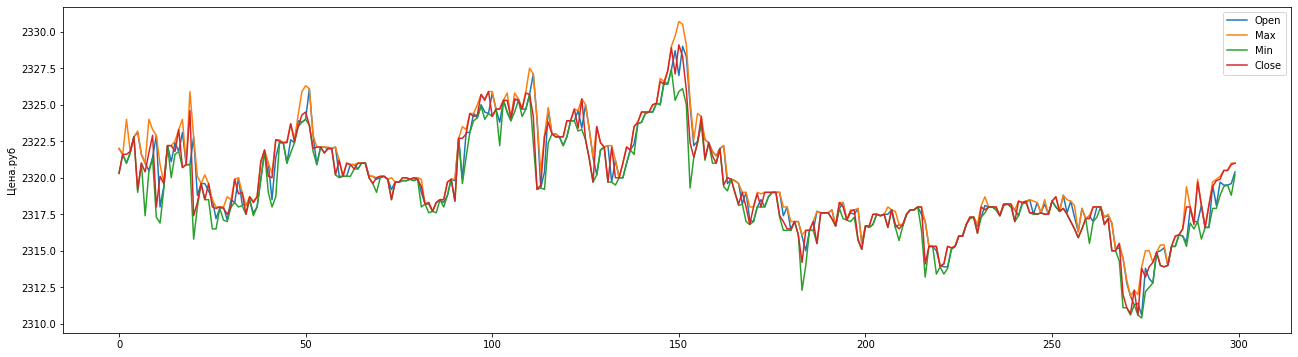

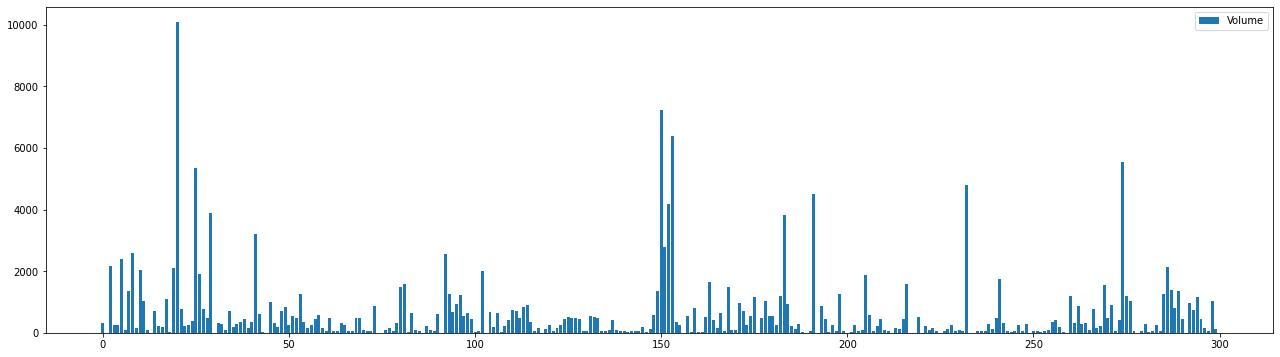

In [ ]:
start = 100
length = 300
columnNames = ['Open', 'Max', 'Min', 'Close', 'Volume']
plt.figure(figsize=(22,6))
for i in range(4):
  plt.plot(data[start:start+length,i], label=columnNames[i])
plt.ylabel('Цена.руб')
plt.legend()
plt.show()

#Канал volume
plt.figure(figsize=(22,6))
plt.bar(x=np.arange(length), height=data[start:start+length,4], label="Volume")
plt.legend()
plt.show()

#**Прогнозирование по 100 прошедшим точкам по столбцу Close - Dense сеть**

**3. Формирование обучающей и проверочной выборки**

In [ ]:
xLen = 100                      #Анализируем по 100 прошедшим точкам 
valLen = 30000                  #Используем 30.000 записей для проверки
trainLen = data.shape[0]-valLen # Размер тренировочной выборки
x_train, x_test = data[:trainLen], data[trainLen+xLen:] #Делим данные на тренировочную и тестовую выборки 

#Нормирование данных
xScaler = MinMaxScaler()
xScaler.fit(x_train)
x_train = xScaler.transform(x_train)
x_test = xScaler.transform(x_test)
print(x_train.shape)
print(x_test.shape)

(451872, 25)
(29900, 25)


In [ ]:
#Формируем правильные и предсказанные ответы из колонки Close
y_train, y_test = np.reshape(data[:trainLen,3],(-1,1)), np.reshape(data[trainLen+xLen:,3],(-1,1))
yScaler = MinMaxScaler()
yScaler.fit(y_train)
y_train = yScaler.transform(y_train)
y_test = yScaler.transform(y_test)
print(y_train.shape)
print(y_test.shape)

(451872, 1)
(29900, 1)


In [ ]:
#Создаем генератор для обучения
train_gen = TimeseriesGenerator(x_train, y_train, length=xLen, stride=1, sampling_rate=1, batch_size=20)
test_gen = TimeseriesGenerator(x_test, y_test, length=xLen, stride=1, sampling_rate=1, batch_size=20)
print(train_gen[0][0].shape)  
print(train_gen[0][1].shape)     

(20, 100, 25)
(20, 1)


**4.Функции визуализации результатов**

In [ ]:
# Функция возвращает предсказанную и правильную Close цену без нормализации
def getPred(currModel, xVal, yVal, yScaler):
  predVal = yScaler.inverse_transform(currModel.predict(xVal)) # Предсказываем ответ сети по проверочной выборке и возвращаем исходны масштаб данных, до нормализации
  yValUnscaled = yScaler.inverse_transform(yVal) # Возвращаем правильный ответ без нормализации
  return (predVal, yValUnscaled)

# Функция визуализирует предсказанную и правильную Close цену без нормализации
def showPredict(start, step, predVal, yValUnscaled):
  plt.figure(figsize=(22,6))
  plt.plot(predVal[start:start+step],
           label='Прогноз')
  plt.plot(yValUnscaled[start:start+step], 
           label='Правильная Close')
  plt.xlabel('Время')
  plt.ylabel('Значение Close')
  plt.legend()
  plt.show()

# Функция расчёта корреляции дух одномерных векторов
def correlate(a, b):
  ma = a.mean() # Среднее значение первого вектора
  mb = b.mean() # Среднее значение второго вектора
  mab = (a*b).mean() # Среднее значение произведения векторов
  sa = a.std() # Среднеквадратичное отклонение первого вектора
  sb = b.std() # Среднеквадратичное отклонение второго вектора
  val = 1
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val

#Функция рисует корреляцию между предсказанной и правильной Close ценой без нормализации, а также между правильной Close ценой на поочередных шагах смещения к самому себе
def showCorr(corrSteps, predVal, yValUnscaled):
  corr = [] # Создаём пустой лист, в нём будут корреляции при смезении на i шагов обратно
  yLen = yValUnscaled.shape[0] # Запоминаем размер проверочной выборки
  for i in range(corrSteps):
    corr.append(correlate(yValUnscaled[:yLen-i], predVal[i:]))
  
  own_corr = [] # Создаём пустой лист, в нём будут корреляции при смезении на i рагов обратно
  for i in range(corrSteps):
    own_corr.append(correlate(yValUnscaled[:yLen-i], yValUnscaled[i:]))
  
  plt.figure(figsize=(14,7))
  plt.plot(corr, label='Предсказание на 1 последующий шаг')
  plt.plot(own_corr, label='Эталон')
  plt.xlabel('Время')
  plt.ylabel('Значение')
  plt.legend()
  plt.show()

#Создадим генератор проверочной выборки, из которой потом вытащим xVal, yVal для проверки
val_gen = TimeseriesGenerator(x_test, y_test, length=xLen, sampling_rate=1, batch_size=len(x_test)) #размер batch будет равен длине нашей выборки
x_val = []
y_val = []
for i in val_gen:
  x_val.append(i[0])
  y_val.append(i[1])

x_val = np.array(x_val)
y_val = np.array(y_val)
print(x_val[0].shape)
print(y_val[0].shape)

(29800, 100, 25)
(29800, 1)


**5. Cоздаем и обучаем сеть**

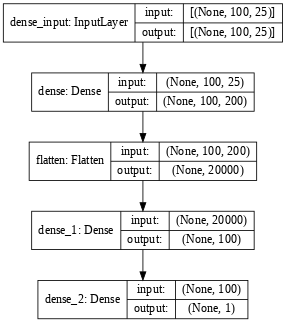

In [ ]:
modelD = Sequential()
modelD.add(Dense(200,input_shape = (xLen,25), activation="relu" ))
modelD.add(Flatten())
modelD.add(Dense(100, activation="relu"))
modelD.add(Dense(1, activation="linear"))

modelD.compile(loss="mse", optimizer=Adam(lr=1e-4))
plot_model(modelD, dpi=60, show_shapes=True)

In [ ]:
history = modelD.fit(train_gen, epochs=30, verbose=1, validation_data = test_gen )

Epoch 1/30
22589/22589 [==============================] - 75s 3ms/step - loss: 6.0981e-04 - val_loss: 2.6312e-04
Epoch 2/30
22589/22589 [==============================] - 71s 3ms/step - loss: 4.2716e-05 - val_loss: 2.1489e-05
Epoch 3/30
22589/22589 [==============================] - 70s 3ms/step - loss: 2.6955e-05 - val_loss: 2.4541e-05
Epoch 4/30
22589/22589 [==============================] - 71s 3ms/step - loss: 1.9796e-05 - val_loss: 2.4481e-05
Epoch 5/30
22589/22589 [==============================] - 71s 3ms/step - loss: 1.5562e-05 - val_loss: 1.2311e-04
Epoch 6/30
22589/22589 [==============================] - 71s 3ms/step - loss: 1.3648e-05 - val_loss: 7.4727e-06
Epoch 7/30
22589/22589 [==============================] - 70s 3ms/step - loss: 1.0985e-05 - val_loss: 2.8694e-06
Epoch 8/30
22589/22589 [==============================] - 70s 3ms/step - loss: 9.8054e-06 - val_loss: 8.8923e-06
Epoch 9/30
22589/22589 [==============================] - 71s 3ms/step - loss: 9.6178e-06 - val_

**- Дообучаем с меньшим learning rate**

In [ ]:
modelD.compile(loss="mse", optimizer=Adam(lr=1e-5))
history = modelD.fit(train_gen, epochs=30, verbose=1, validation_data = test_gen )

Epoch 1/30
22589/22589 [==============================] - 70s 3ms/step - loss: 6.8973e-07 - val_loss: 7.8763e-07
Epoch 2/30
22589/22589 [==============================] - 70s 3ms/step - loss: 6.3424e-07 - val_loss: 6.7635e-07
Epoch 3/30
22589/22589 [==============================] - 70s 3ms/step - loss: 6.1776e-07 - val_loss: 1.3145e-06
Epoch 4/30
22589/22589 [==============================] - 70s 3ms/step - loss: 6.0864e-07 - val_loss: 6.3261e-07
Epoch 5/30
22589/22589 [==============================] - 70s 3ms/step - loss: 5.9895e-07 - val_loss: 1.8308e-06
Epoch 6/30
22589/22589 [==============================] - 69s 3ms/step - loss: 5.9024e-07 - val_loss: 7.2083e-07
Epoch 7/30
22589/22589 [==============================] - 69s 3ms/step - loss: 5.8100e-07 - val_loss: 5.9659e-07
Epoch 8/30
22589/22589 [==============================] - 69s 3ms/step - loss: 5.6511e-07 - val_loss: 8.8669e-07
Epoch 9/30
22589/22589 [==============================] - 70s 3ms/step - loss: 5.5343e-07 - val_

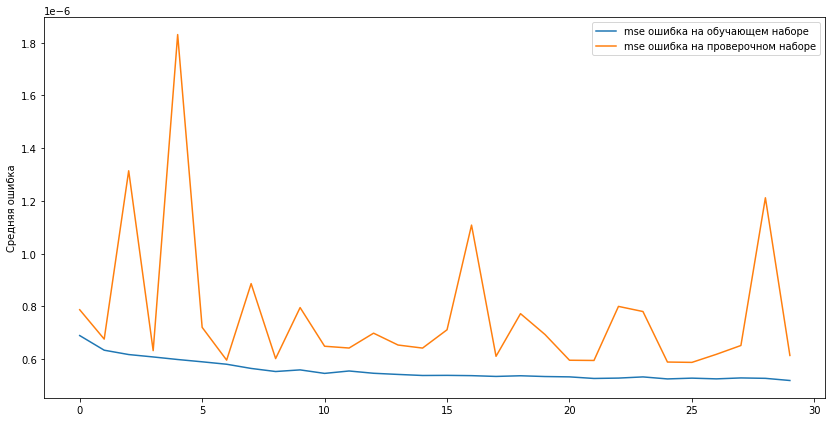

In [ ]:
#Выводим графики ошибок
plt.figure(figsize=(14,7))
plt.plot(history.history['loss'], 
         label='mse ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='mse ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

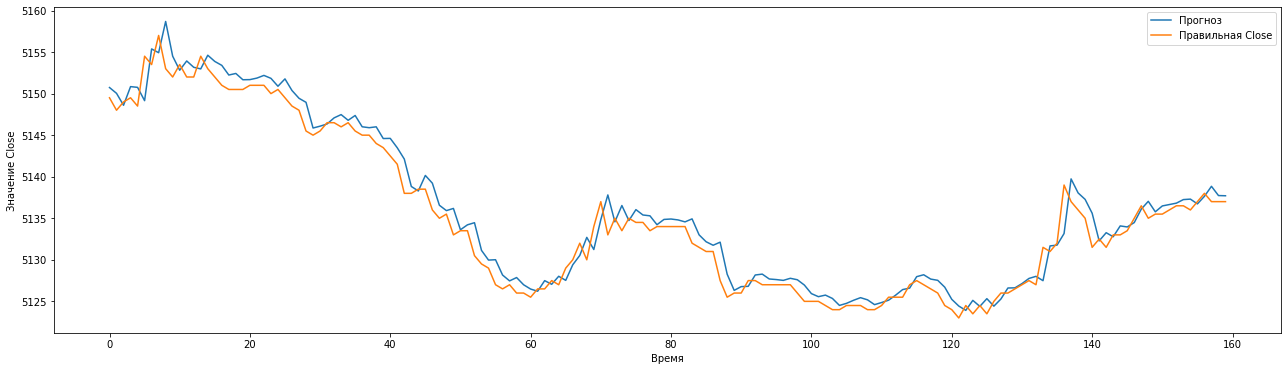

In [ ]:
#Прогнозируем предсказанную и правильную Close цену без нормализации
currModel = modelD #Выбираем текущую модель
(predVal, yValUnscaled) = getPred(currModel, x_val[0], y_val[0], yScaler) #Прогнозируем данные
#Отображаем предсказанную и правильную Close цену без нормализации
showPredict(0, 160, predVal, yValUnscaled)

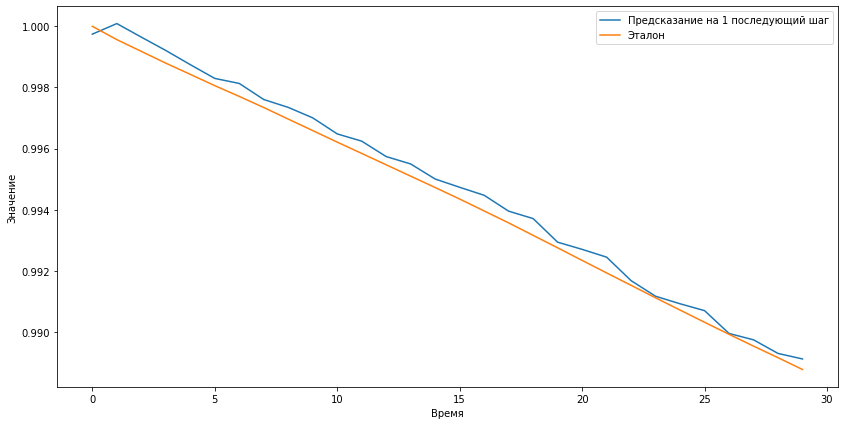

In [ ]:
#Отображаем корреляцию
#Проверяем корреляцию на глубину 30 шагов
showCorr(30, predVal, yValUnscaled)

#**Прогнозирование по 100 прошедшим точкам с шагом назад по 10 по столбцу Close - Dense сеть**

**3. Формирование обучающей и проверочной выборки**

In [ ]:
xLen = 100                      #Анализируем по 100 прошедшим точкам с шагом назад по 10
valLen = 30000                  #Используем 30.000 записей для проверки
trainLen = data.shape[0]-valLen # Размер тренировочной выборки
x_train10, x_test10 = data[:trainLen], data[trainLen+10*xLen:] #Делим данные на тренировочную и тестовую выборки 

#Нормирование данных
xScaler = MinMaxScaler()
xScaler.fit(x_train10)
x_train10 = xScaler.transform(x_train10)
x_test10 = xScaler.transform(x_test10)
print(x_train10.shape)
print(x_test10.shape)

(451872, 25)
(29000, 25)


In [ ]:
#Формируем правильные и предсказанные ответы из колонки Close
y_train10, y_test10 = np.reshape(data[:trainLen,3],(-1,1)), np.reshape(data[trainLen+10*xLen:,3],(-1,1))
yScaler = MinMaxScaler()
yScaler.fit(y_train10)
y_train10 = yScaler.transform(y_train10)
y_test10 = yScaler.transform(y_test10)
print(y_train10.shape)
print(y_test10.shape)

(451872, 1)
(29000, 1)


In [ ]:
#Создаем генератор для обучения
train_gen10 = TimeseriesGenerator(x_train10, y_train10, length=10*xLen, stride=1, sampling_rate=10, batch_size=20)
test_gen10 = TimeseriesGenerator(x_test10, y_test10, length=10*xLen, stride=1, sampling_rate=10, batch_size=20)
print(train_gen10[0][0].shape)  
print(test_gen10[0][1].shape)  

(20, 100, 25)
(20, 1)


In [ ]:
#Создадим генератор проверочной выборки, из которой потом вытащим xVal, yVal для проверки
val_gen10 = TimeseriesGenerator(x_test10, y_test10, length=10*xLen, stride=1, sampling_rate=10, batch_size=len(x_test10)) #размер batch будет равен длине нашей выборки
x_val10 = []
y_val10 = []
for i in val_gen10:
  x_val10.append(i[0])
  y_val10.append(i[1])

x_val10 = np.array(x_val10)
y_val10 = np.array(y_val10)
print(x_val10[0].shape)
print(y_val10[0].shape)

(28000, 100, 25)
(28000, 1)


**5. Cоздаем и обучаем сеть**

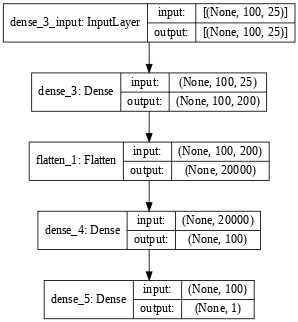

In [ ]:
modelD10 = Sequential()
modelD10.add(Dense(200,input_shape = (xLen,25), activation="relu" ))
modelD10.add(Flatten())
modelD10.add(Dense(100, activation="relu"))
modelD10.add(Dense(1, activation="linear"))

modelD10.compile(loss="mse", optimizer=Adam(lr=1e-4))
plot_model(modelD10, dpi=60, show_shapes=True)

In [ ]:
history = modelD10.fit(train_gen10, epochs=30, verbose=1, validation_data = test_gen10 )

Epoch 1/30
22544/22544 [==============================] - 73s 3ms/step - loss: 8.5427e-04 - val_loss: 7.8534e-05
Epoch 2/30
22544/22544 [==============================] - 71s 3ms/step - loss: 8.7444e-05 - val_loss: 3.7866e-05
Epoch 3/30
22544/22544 [==============================] - 71s 3ms/step - loss: 6.0699e-05 - val_loss: 1.4350e-04
Epoch 4/30
22544/22544 [==============================] - 71s 3ms/step - loss: 4.9137e-05 - val_loss: 2.3997e-05
Epoch 5/30
22544/22544 [==============================] - 71s 3ms/step - loss: 4.2843e-05 - val_loss: 5.5371e-04
Epoch 6/30
22544/22544 [==============================] - 70s 3ms/step - loss: 3.6510e-05 - val_loss: 3.6231e-04
Epoch 7/30
22544/22544 [==============================] - 71s 3ms/step - loss: 3.3881e-05 - val_loss: 1.9585e-05
Epoch 8/30
22544/22544 [==============================] - 71s 3ms/step - loss: 2.9644e-05 - val_loss: 1.6214e-04
Epoch 9/30
22544/22544 [==============================] - 70s 3ms/step - loss: 2.7240e-05 - val_

**- Дообучаем с меньшим learning rate**

In [ ]:
modelD10.compile(loss="mse", optimizer=Adam(lr=1e-5))
history = modelD10.fit(train_gen10, epochs=30, verbose=1, validation_data = test_gen10 )

Epoch 1/30
22544/22544 [==============================] - 72s 3ms/step - loss: 6.9450e-06 - val_loss: 1.0308e-05
Epoch 2/30
22544/22544 [==============================] - 70s 3ms/step - loss: 6.7290e-06 - val_loss: 1.1092e-05
Epoch 3/30
22544/22544 [==============================] - 70s 3ms/step - loss: 6.6835e-06 - val_loss: 1.1421e-05
Epoch 4/30
22544/22544 [==============================] - 70s 3ms/step - loss: 6.6362e-06 - val_loss: 1.2091e-05
Epoch 5/30
22544/22544 [==============================] - 70s 3ms/step - loss: 6.6094e-06 - val_loss: 1.1020e-05
Epoch 6/30
22544/22544 [==============================] - 69s 3ms/step - loss: 6.5573e-06 - val_loss: 1.0086e-05
Epoch 7/30
22544/22544 [==============================] - 70s 3ms/step - loss: 6.5008e-06 - val_loss: 1.0258e-05
Epoch 8/30
22544/22544 [==============================] - 70s 3ms/step - loss: 6.5049e-06 - val_loss: 1.1593e-05
Epoch 9/30
22544/22544 [==============================] - 70s 3ms/step - loss: 6.4479e-06 - val_

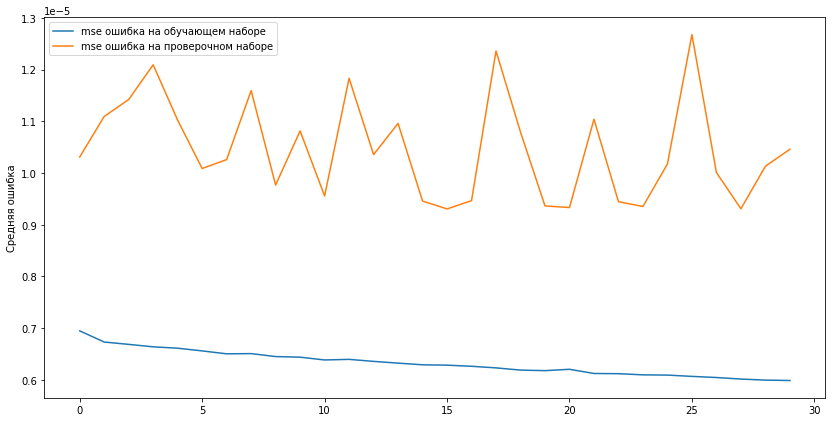

In [ ]:
#Выводим графики ошибок
plt.figure(figsize=(14,7))
plt.plot(history.history['loss'], 
         label='mse ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='mse ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

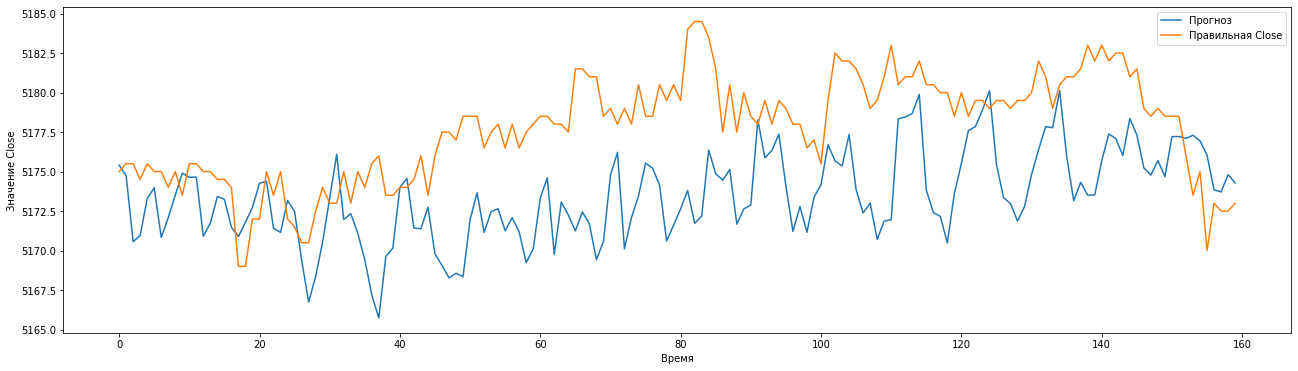

In [ ]:
#Прогнозируем предсказанную и правильную Close цену без нормализации
currModel = modelD10 #Выбираем текущую модель
(predVal, yValUnscaled) = getPred(currModel, x_val10[0], y_val10[0], yScaler) #Прогнозируем данные
#Отображаем предсказанную и правильную Close цену без нормализации
showPredict(0, 160, predVal, yValUnscaled)

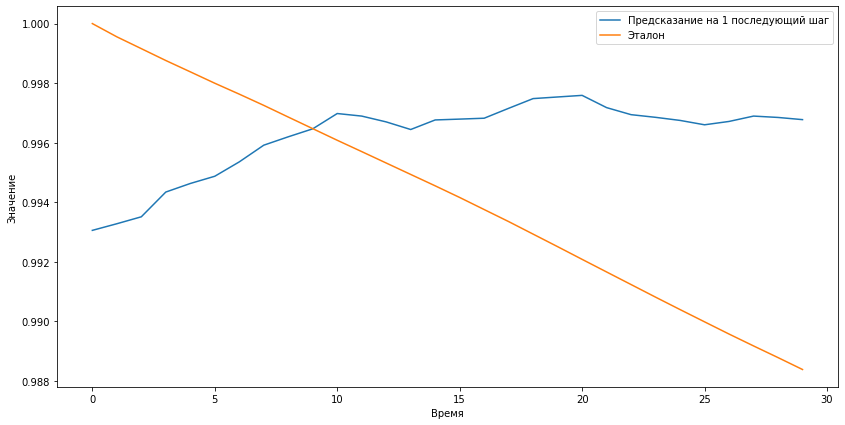

In [ ]:
#Отображаем корреляцию
#Проверяем корреляцию на глубину 30 шагов
showCorr(30, predVal, yValUnscaled)

В первом варианте явный повтор со смещением, а прогнозирование по точкам с шагом через 10 дает более менее нормальную корреляцию и этот вариант можно пробывать дорабатывать понижая ошибку - попробовать разные модели, дообучить итд.